## SpaceX Falcon 9 First Stage Landing Prediction

### Machine Learning Prediction

Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch. In this notebook, I will create a machine learning pipeline to predict if the first stage will land given the data from the preceding notebooks.

### Objective

Perfrom exploratory Data Analysis and determine Training Labels
- create a column for the class
- standardize the data
- split into training data and test data

Find best Hyperparameter for SVM, Classifiction Trees and Logistic Regression
- Find the method performs best using test data

### Import Libraries and Auxiliary Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix

In [2]:
def plot_confusion_matrix(y, y_predict):
    # this function plots the confusion matrix
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(['did not land', 'land'])
    ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

### Load the Dataframe

In [3]:
data = pd.read_csv('dataset_with_json_2.csv')
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
X = pd.read_csv("dataset_part_3.csv")
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


### Ready the Data for Training Model

In [5]:
y = pd.Series(data['Class'].to_numpy())
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

Now we standardize the data in X then reassign it to the variable X using the transform provided.

In [6]:
transform = preprocessing.StandardScaler()
X = transform.fit(X).transform(X)

In [7]:
X

array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

We split the data into training and testing data using the function `train_test_split`. The training data is divided into validation data, a second set used for training data then the models are trained and hyperparameters are selected using the function `GridSearchCV`.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [9]:
y_test.shape

(18,)

### Logistic Regression

Create a logistic regression object then create a GridSearchCV object `logreg_cv` with cv=10. Fit the object to find the best parameters from the dictionary `parameters`.

In [10]:
parameters = {'C': [0.01, 0.1, 1],
              'penalty': ['l2'], # l1 lasso, l2 Ridge
              'solver': ['lbfgs']}

lr = LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the GridSearchCV object for logistic regression. Now display the best parameters using the data attribute `best_params_` and the accuracy on the validation data using the data attribute `best_score_`.

In [11]:
print('Tuned hyperparameters: (best parameters)', logreg_cv.best_params_)
print('Accuracy: ', logreg_cv.best_score_)

Tuned hyperparameters: (best parameters) {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy:  0.8464285714285713


Calculate the accuracy on the test data using the method `score`:

In [12]:
logreg_accuracy = logreg_cv.score(X_test, y_test)
logreg_accuracy

0.8333333333333334

Let's Look at the confusion matrix

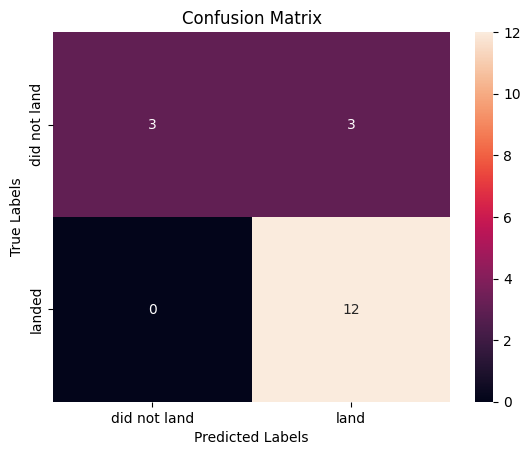

In [13]:
logreg_yhat = logreg_cv.predict(X_test)
plot_confusion_matrix(y_test, logreg_yhat)

Examining the confusion matrix, We see that logistic Regression can distinguish between the different classes. We see that the major problem is false positive.

### Support Vector Machine

Create a support vector machine object then create a `GridSearchCV` object `svm_cv` with cv=10. Fit the object to find the best parameters from the dictionary `parameters`.

In [20]:
parameters = {'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma': np.logspace(-3, 3, 5)}

svm = SVC()

In [21]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [22]:
print("Tuned hyperparameter: (best parameters)", svm_cv.best_params_)
print('Accuracy: ', svm_cv.best_score_)

Tuned hyperparameter: (best parameters) {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
Accuracy:  0.8482142857142856


Calculate the accuracy on the test data using the method `score`:

In [23]:
svm_accuracy = svm_cv.score(X_test, y_test)
svm_accuracy

0.8333333333333334

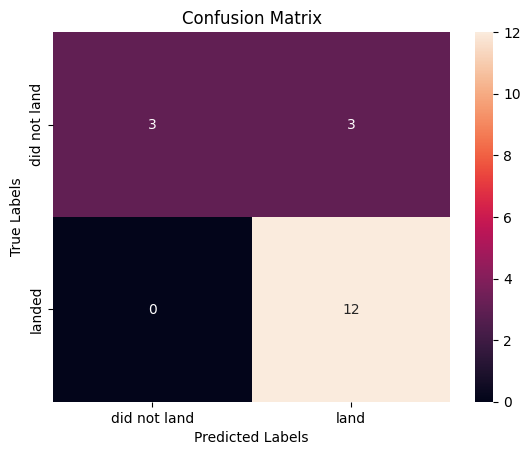

In [25]:
svm_yhat = svm_cv.predict(X_test)
plot_confusion_matrix(y_test, svm_yhat)

### Decision Tree Classifier

Create a decision tree classifier object then create a `GridSearchCV` object `tree_cv` with cv=10. Fit the object to find the best parameters from dictionary `parameters`.

In [38]:
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1, 10)],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [39]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, y_train)

c:\Users\cW\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cW\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\cW\anaconda3\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\cW\anaconda3\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\cW\anaconda3\lib\site-packages\sklearn\u

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [40]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8892857142857142


Calculate the accuracy of tree_cv on the test data using the method score:

In [41]:
tree_accuracy = tree_cv.score(X_test, y_test)
tree_accuracy

0.7777777777777778

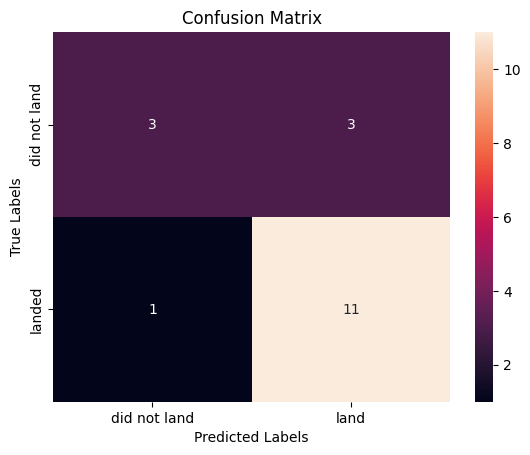

In [42]:
tree_yhat = tree_cv.predict(X_test)
plot_confusion_matrix(y_test,tree_yhat)

### K-Nearest Neighbors

Create a k nearest neighbors object then create a `GridSearchCV` object `knn_cv` with cv=10. Fit the object to find the best parameters from the dictionary `parameters`.

In [43]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
KNN = KNeighborsClassifier()

In [44]:
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [45]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


Calculate the accuracy of knn_cv on the test data using the method score:

In [47]:
knn_accuracy = knn_cv.score(X_test, y_test)
knn_accuracy

0.8333333333333334

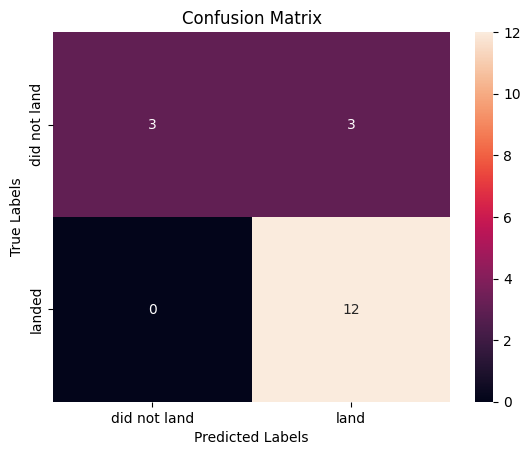

In [48]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(y_test,knn_yhat)

### Finding Best Model

In [50]:
from sklearn.metrics import jaccard_score, f1_score

# Examining the scores from Test sets
jaccard_scores = [
    jaccard_score(y_test, logreg_yhat, average='binary'),
    jaccard_score(y_test, svm_yhat, average='binary'),
    jaccard_score(y_test, tree_yhat, average='binary'),
    jaccard_score(y_test, knn_yhat, average='binary'),
]

f1_scores = [
    f1_score(y_test, logreg_yhat, average='binary'),
    f1_score(y_test, svm_yhat, average='binary'),
    f1_score(y_test, tree_yhat, average='binary'),
    f1_score(y_test, knn_yhat, average='binary'),
]

accuracy = [logreg_accuracy, svm_accuracy, tree_accuracy, knn_accuracy]

scores = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]), index=['Jaccard_Score', 'F1_Score', 'Accuracy'])
scores

,0,1,2,3
Jaccard_Score,0.800000,0.800000,0.733333,0.800000
F1_Score,0.888889,0.888889,0.846154,0.888889
Accuracy,0.833333,0.833333,0.777778,0.833333


In [52]:
# Examining the scores from the whole Dataset
jaccard_scores = [
                  jaccard_score(y, logreg_cv.predict(X), average='binary'),
                  jaccard_score(y, svm_cv.predict(X), average='binary'),
                  jaccard_score(y, tree_cv.predict(X), average='binary'),
                  jaccard_score(y, knn_cv.predict(X), average='binary'),
                 ]

f1_scores = [
             f1_score(y, logreg_cv.predict(X), average='binary'),
             f1_score(y, svm_cv.predict(X), average='binary'),
             f1_score(y, tree_cv.predict(X), average='binary'),
             f1_score(y, knn_cv.predict(X), average='binary'),
            ]

accuracy = [logreg_cv.score(X, y), svm_cv.score(X, y), tree_cv.score(X, y), knn_cv.score(X, y)]

scores = pd.DataFrame(np.array([jaccard_scores, f1_scores, accuracy]),
                      index=['Jaccard_Score', 'F1_Score', 'Accuracy'],
                      columns=['LogReg', 'SVM', 'Tree', 'KNN'])
scores

,LogReg,SVM,Tree,KNN
Jaccard_Score,0.833333,0.845070,0.774648,0.819444
F1_Score,0.909091,0.916031,0.873016,0.900763
Accuracy,0.866667,0.877778,0.822222,0.855556


### Conclusion
- Based on the scores of the Test Set, we can not confirm which method performs best.
- Same Test Set scores may be due to the small test sample size (18 samples). Therefore, we tested all methods based on the whole Dataset.
- The scores of the whole Dataset confirm that the best model is the Decision Tree Model. This model has not only higher scores, but also the highest accuracy.